In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import math
import random
%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tqdm import tqdm
from utils import show_images

### Limitations:

This approach won't work correctly when the camera is not fixed during the whole video. It also fails in case of very noticeable changes in lighting conditions. Let $f_s$ be the index of the still frame we are looking for, $f_d$ a frame during the drop of the caps and $f_v$ the maximum number of frames in the video.

Assumptions on $f_d$: It is reasonable to say that $0.1 f_v \leq f_d \leq 0.45 f_v$. Of course, the frame we are looking for will be $f_s > f_d$, more precisely will be the index of frame with lowest difference found after $f_d$.

In [2]:
# https://stackoverflow.com/questions/189943/how-can-i-quantify-difference-between-two-images

In [3]:
# cap = cv2.VideoCapture("dataset/videos/CV20_video_129.mp4")
# cap = cv2.VideoCapture("dataset/videos/CV20_video_145.mp4") # bad
# cap = cv2.VideoCapture("dataset/videos/CV20_video_153.mp4") # bad
# cap = cv2.VideoCapture("dataset/videos/CV20_video_38.mp4")
# cap = cv2.VideoCapture("dataset/videos/CV20_video_121.mp4")
cap = cv2.VideoCapture("../dataset/videos/CV20_video_15.mp4") # bad
number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
original_frames = []
frames = []

for _ in tqdm(range(number_of_frames)):

    ret, frame = cap.read()

    if cv2.waitKey(1) & 0xFF == ord('q') or ret==False :
        cap.release()
        break 
        
    original_frames.append(frame)
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray)

print("Number of frames in the video: ", len(frames))    

# focus only on the central part of the video, excluding most of the "ending"
ub = 7/10
lb = 0.2/10
last_frame = math.floor(len(frames) * ub)
first_frame = math.floor(len(frames) * lb)

frames = frames[first_frame:last_frame]
img_pixels = (frames[0].shape[0] * frames[0].shape[1])

print(str(len(frames)), "frames under analysis, corresponding to the " + str(int(round((ub - lb)* 100, 2))) + "% of the video frames")

100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:09<00:00, 63.67it/s]

Number of frames in the video:  585
398 frames under analysis, corresponding to the 68% of the video frames


In [4]:
smoothed_frames = []
for i in tqdm(range(len(frames))):
    median_blur = cv2.medianBlur(frames[i], 7)
    smoothed_frames.append(median_blur)
frames = smoothed_frames

100%|████████████████████████████████████████████████████████████████████████████████| 398/398 [00:26<00:00, 15.04it/s]


In [6]:
# Find frame with smallest difference from its
# predecessors and successors
window_width = 7
min_pixel_value = 20

differences = []
for i in tqdm(range(window_width // 2, len(frames) - window_width // 2, 1)):
    
    accumulation = np.zeros(frames[0].shape)
    for j in range(i - window_width // 2, i + window_width // 2, 1):
        if i != j: 
            weight = 1 / abs(j - i) 
            accumulation += weight * cv2.absdiff(frames[i], frames[j]);
            
    _, thresholded = cv2.threshold(accumulation, min_pixel_value, 255, cv2.THRESH_BINARY)
    diff = (sum(sum(thresholded / 255)) / img_pixels) * 100
    differences.append(diff)
    
differences = np.array(differences)
differences = np.round(differences, 2)

100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:22<00:00, 17.76it/s]


In [57]:
def plot_differences(index):
    # differences without threshold
    # frame = random.randint(window_width // 2, len(frames) - 1 - window_width // 2) # pick a random frame
    
    abs_diff_prec = cv2.absdiff(frames[index], frames[index - 2])
    abs_diff_succ = cv2.absdiff(frames[index], frames[index + 2])
    '''
    show_images([
                    abs_diff_prec,
                    frames[index], 
                    abs_diff_succ,
                ],
                titles=["absdiff( frame[" + str(index) + "], frame[" + str(index - 2) + "] )", "frame[" + str(index) + "]", "absdiff( frame[" + str(index) + "], frame[" + str(index + 2) + "] )"])
    '''
    min_pixel_value = 20
    _, thresholded_prec = cv2.threshold(abs_diff_prec, min_pixel_value, 255, cv2.THRESH_BINARY)
    _, thresholded_succ = cv2.threshold(abs_diff_succ, min_pixel_value, 255, cv2.THRESH_BINARY)
    diff_prec = round((sum(sum(thresholded_prec / 255)) / img_pixels) * 100, 2)
    diff_succ = round((sum(sum(thresholded_succ / 255)) / img_pixels) * 100, 2)
    '''
    show_images([
                    thresholded_prec,
                    frames[index], 
                    thresholded_succ,
                ],
                titles=["thresholded absdiff( frame[" + str(index) + "], frame[" + str(index - 2) + "] )", "frame[" + str(index) + "]", "thresholded absdiff( frame[" + str(index) + "], frame[" + str(index + 2) + "] )"])
    '''
    show_images([
                    frames[index],
                    thresholded_prec, 
                    thresholded_succ
                ],
                titles=["frame[" + str(index) + "]", str(diff_prec) + "% diffs with frame[" + str(index - 2) + "]", str(diff_succ) + "% diffs with frame[" + str(index + 2) + "]"],
                figsize = (4, 4))
    
interact(plot_differences, index=widgets.IntSlider(min=2, max=len(frames) - 3, step=1, value=82, continuous_update=False));

interactive(children=(IntSlider(value=82, continuous_update=False, description='index', max=395, min=2), Outpu…

In [15]:
# clamp differences at average diff value
avg = np.average(differences)
avg_cut_differences = differences.copy()
avg_cut_differences[np.where(avg_cut_differences > avg)] = avg

In [16]:
# find maximum in the first drop_ub % of frames
# the frame with max differences should correspond to the moment caps are dropped
drop_ub = 0.65
drop_ub_frame = int(len(avg_cut_differences) * drop_ub)
frame_caps_dropped = np.argmax(avg_cut_differences[:drop_ub_frame]) 

In [17]:
# the static frame we are looking for will be the one with lowest error after 
# the frame where caps are dropped

# get all indices of frames with equal lowest error
min_diff_after_caps_drop = avg_cut_differences[frame_caps_dropped:].min()
selected_frames = np.where(avg_cut_differences == min_diff_after_caps_drop)

# take the one with highest index
selected_frame = np.max(selected_frames) 
print("Selected frame in trimmed video: ", selected_frame)

Selected frame in trimmed video:  68


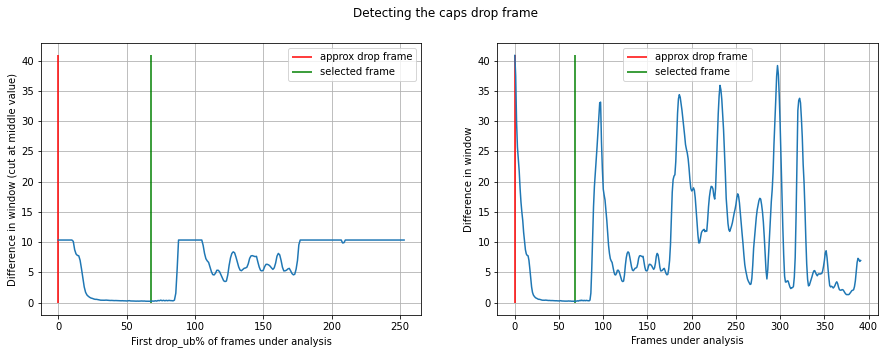

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Detecting the caps drop frame')

x = np.arange(0, drop_ub_frame)
y = avg_cut_differences[:drop_ub_frame]
ax1.vlines(frame_caps_dropped, 0, max(differences[:drop_ub_frame]), colors='r', linestyles='solid', label='approx drop frame')
ax1.vlines(selected_frame, 0, max(differences), colors='g', linestyles='solid', label='selected frame')
ax1.grid()
ax1.plot(x, y)
ax1.set_xlabel('First drop_ub% of frames under analysis')
ax1.set_ylabel('Difference in window (cut at middle value)')
ax1.legend()

x = np.arange(0, len(differences))
y = differences
ax2.vlines(frame_caps_dropped, 0, max(differences[:drop_ub_frame]), colors='r', linestyles='solid', label='approx drop frame')
ax2.vlines(selected_frame, 0, max(differences), colors='g', linestyles='solid', label='selected frame')
ax2.grid()
ax2.plot(x, y)
ax2.set_xlabel('Frames under analysis')
ax2.set_ylabel('Difference in window')
ax2.legend()

plt.show()

ORIGINAL VIDEO: lower bound:  11  selected frame:  82  upper bound:  409


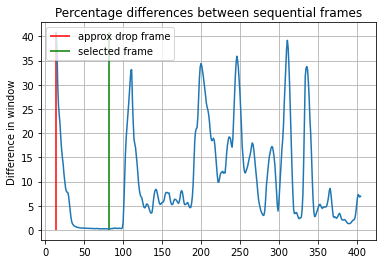

In [58]:
original_frame_caps_dropped = frame_caps_dropped + first_frame + window_width // 2
original_selected_frame = selected_frame + first_frame + window_width // 2
print("ORIGINAL VIDEO: lower bound: ", first_frame, " selected frame: ", original_selected_frame, " upper bound: ", last_frame)

x = np.arange(first_frame + window_width // 2, last_frame - window_width // 2)
y = differences
plt.plot(x, y)
plt.vlines(original_frame_caps_dropped, 0, max(differences), colors='r', linestyles='solid', label='approx drop frame')
plt.vlines(original_selected_frame, 0, max(differences), colors='g', linestyles='solid', label='selected frame')
plt.grid()
plt.ylabel('Difference in window')
plt.title('Percentage differences between sequential frames')
plt.legend()
plt.show()

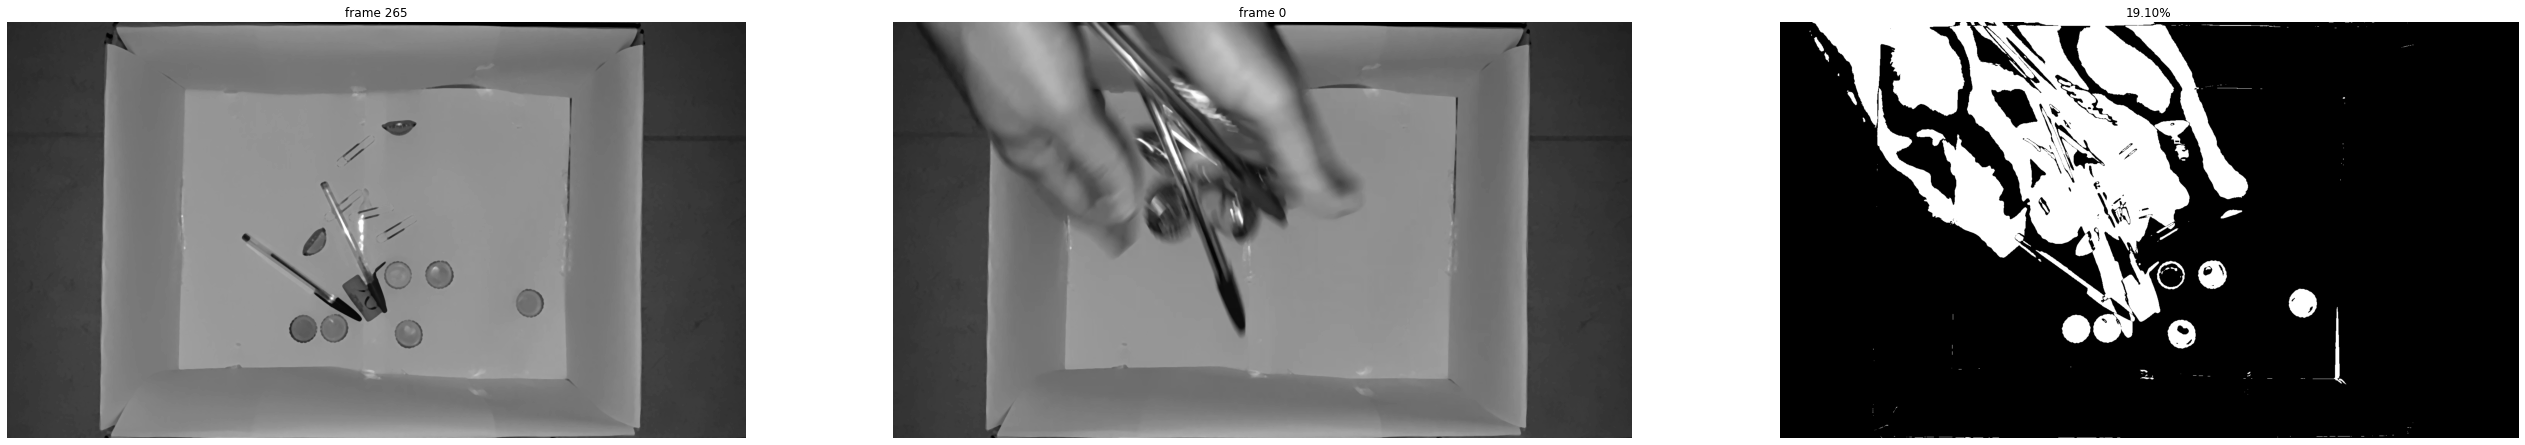

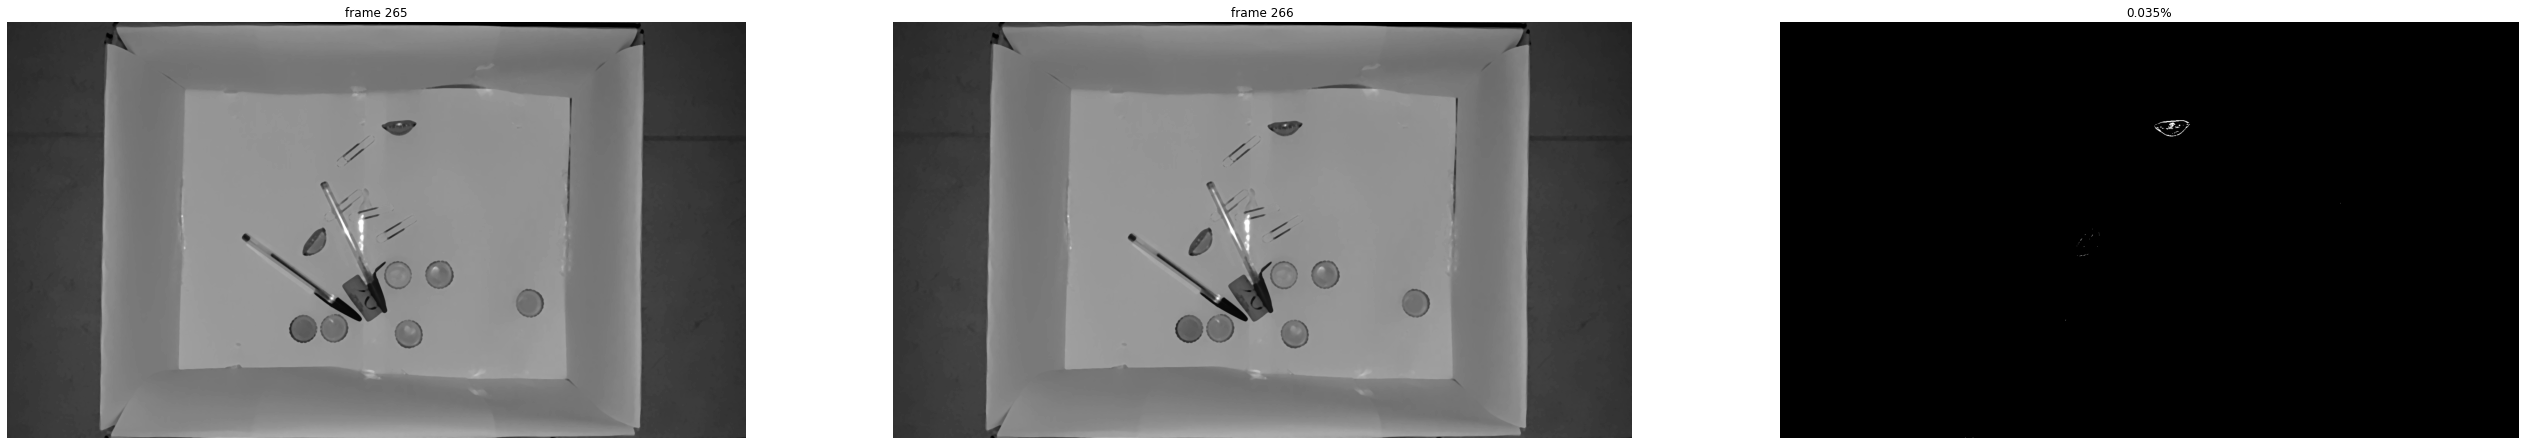

In [23]:
# differences with threshold
_, thresholded_1 = cv2.threshold(cv2.absdiff(frames[selected_frame], frames[0]), min_pixel_value, 255, cv2.THRESH_BINARY)
diff_1 = (sum(sum(thresholded_1 / 255)) / img_pixels) * 100

_, thresholded_2 = cv2.threshold(cv2.absdiff(frames[selected_frame], frames[selected_frame + 1]), min_pixel_value, 255, cv2.THRESH_BINARY)
diff_2 = (sum(sum(thresholded_2 / 255)) / img_pixels) * 100

show_images([frames[selected_frame], frames[0], thresholded_1], titles=["frame " + str(frame), "frame 0", str(diff_1)[:5] + "%"], figsize=(15, 10))
show_images([frames[selected_frame], frames[selected_frame + 1], thresholded_2], titles=["frame " + str(frame), "frame " + str(frame + 1), str(diff_2)[:5] + "%"], figsize=(15, 10))

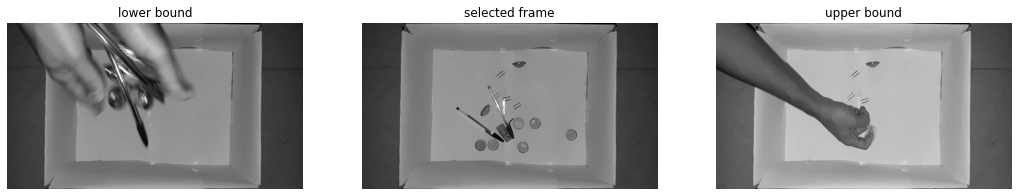

In [24]:
show_images([frames[0], frames[selected_frame], frames[-1]], titles=["lower bound", "selected frame", "upper bound"], cmap='gray')

In [25]:
def plot_frame(index):
    plt.figure(figsize=(15, 10))
    img = original_frames[index]
    plt.imshow(img[...,::-1])

interact(plot_frame, index=widgets.IntSlider(min=0, max=len(original_frames) - 1, step=1, value=original_selected_frame, continuous_update=False));

interactive(children=(IntSlider(value=82, continuous_update=False, description='index', max=584), Output()), _…